In [2]:
!pip install /user-home/py_packages/catboost-0.6.3-cp27-none-manylinux1_x86_64.whl

!pip install /user-home/py_packages/mlxtend-0.11.0-py2.py3-none-any.whl

In [3]:
import sys 
sys.path.append('/user-home/1014/code')
from eval_functions import *
from pdp import *
from mlxtend.classifier import StackingCVClassifier
%matplotlib inline

import matplotlib.pyplot as plt

from __future__ import division
import numpy as np
np.random.seed(198908)
import pandas as pd

from sklearn.model_selection import cross_val_score,cross_val_predict
pd.set_option("display.max_columns",999)
from catboost import CatBoostClassifier,CatBoostRegressor,cv

import os
os.environ["JOBLIB_TEMP_FOLDER"] = "/tmp"


import xgboost as xgb
import xgbfir
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.model_selection import PredefinedSplit,  cross_val_predict, GridSearchCV, StratifiedKFold, train_test_split, KFold , RandomizedSearchCV

from sklearn.externals import joblib

from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb 

from sklearn.feature_selection import SelectKBest, chi2

from pyearth  import Earth
from xgboost import XGBRegressor


import patsy
from patsy import dmatrix, build_design_matrices

from sklearn.linear_model import LogisticRegressionCV

def plot_single_var_response(X,var_name, response_name, bins):
    X['decile']=(bins)-(pd.qcut(X[var_name],bins,labels=False,duplicates='drop'))
    bin_toPlot=X.groupby('decile')[response_name].mean()
    fig, ax = plt.subplots()
    ax.plot(bin_toPlot)
    ax.set_xlabel("Bin")
    ax.set_ylabel("Average Target")
    ax.legend()




def oversample_2class(x,y,prop,seed=0,save_msk_path=None, shuffle=True):
    
    y_pos=y.loc[(y.values).flatten()==1]
    x_pos =x.loc[(y.values).flatten()==1,:]
    
    nb_pos=y_pos.shape[0]
    nb_neg = (nb_pos / prop) - nb_pos
    
    ttl_neg=x.loc[(y.values).flatten()==0,:]
    np.random.seed(seed)
    indx_msk=np.random.choice(a=ttl_neg.shape[0], size=int(nb_neg),replace = False)
    
    sampled_negx=x.iloc[indx_msk,:]
    sampled_negy=y.iloc[indx_msk]
    
    finalx_df=pd.concat([x_pos,sampled_negx],axis=0)
    finaly_df=pd.concat([y_pos,sampled_negy],axis=0)
    
    
    if save_msk_path != None:
        joblib.dump(indx_msk,save_msk_path)
        
    
    if shuffle:
        indx_perm=np.random.permutation(finalx_df.shape[0])
        finalx_df=finalx_df.iloc[indx_perm,:]
        finaly_df=finaly_df.iloc[indx_perm,:]
        
        
        
    return(finalx_df,finaly_df)



from scipy.stats import randint as sp_randint, uniform


In [28]:
mar_orig=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/MAR_18_original.txt', na_values=['.', 'null'], dtype={'block_group':np.object, 'census_tract': np.object})


In [29]:
#random sample for a test set

msk_test = np.random.rand(len(mar_orig)) < 0.25
x_test = mar_orig[msk_test].drop('responder' ,axis=1)
y_test = mar_orig[msk_test].responder

x_test.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_testX.csv',header=True,index=False)
y_test.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_testy.csv',header=True,index=False)

joblib.dump(msk_test,'/user-home/1014/checking_models/response_rebuild/high_bal_response/msk_mar_orig_test.mask')

#non-test
remain=mar_orig[~msk_test]

del mar_orig

x_train = remain.drop('responder' ,axis=1)
y_train = remain.responder

x_train.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_trainX.csv',header=True,index=False)
y_train.to_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_trainy.csv',header=True,index=False)



del remain

In [8]:
x_train=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_trainX.csv')
y_train=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_trainy.csv')


In [9]:
x_test=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_testX.csv')
y_test=pd.read_csv('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_testy.csv')

fold 1 completed.
fold 2 completed.
fold 3 completed.
fold 4 completed.
fold 5 completed.
fold 6 completed.
fold 7 completed.
fold 8 completed.
fold 9 completed.
fold 10 completed.
AUC is: 0.536129803916
KS: 0.0542542104924
Total Responders: 5770.0
Lift Bin 1 (Vs Mean): 1.22183142006
Lift Bin 1 (Vs Last Bin): 1.47489539749


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,172444,705,0.004088,0.005168,1.221831,172444,705,0.004088,1.221831,0.004617,0.120494
1,2,172443,676,0.003920,0.004363,1.171578,344887,1381,0.004004,1.196705,0.004160,0.004617
2,3,172443,660,0.003827,0.004014,1.143849,517330,2041,0.003945,1.179086,0.003883,0.004160
3,4,172443,579,0.003358,0.003772,1.003467,689773,2620,0.003798,1.135182,0.003668,0.003883
4,5,172443,561,0.003253,0.003572,0.972271,862216,3181,0.003689,1.102600,0.003479,0.003668
5,6,172443,562,0.003259,0.003390,0.974005,1034659,3743,0.003618,1.081167,0.003302,0.003479
6,7,172443,511,0.002963,0.003214,0.885616,1207102,4254,0.003524,1.053231,0.003127,0.003302
7,8,172443,552,0.003201,0.003036,0.956674,1379545,4806,0.003484,1.041162,0.002943,0.003127
8,9,172443,486,0.002818,0.002836,0.842289,1551988,5292,0.003410,1.019065,0.002716,0.002943
9,10,172444,478,0.002772,0.002448,0.828419,1724432,5770,0.003346,1.000000,0.000000,0.002716


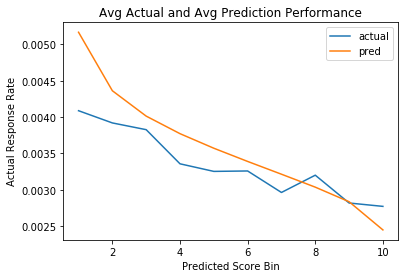

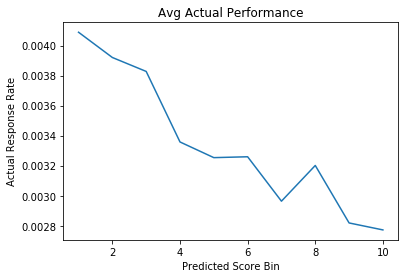

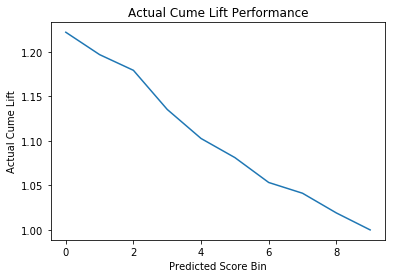

In [15]:
#hold results for training and oof
hold_results=np.zeros((x_train.shape[0],4))

#define folds
kf = KFold(n_splits=10,random_state=4528996)
counter =1

for train_index, test_index in kf.split(x_train.values):
    X_train, X_test = x_train.drop([u'unique_id', u'Person_Seq_No_1_183'],axis=1).iloc[train_index], x_train.drop([u'unique_id', u'Person_Seq_No_1_183'],axis=1).iloc[test_index]
    Y_train, Y_test = y_train.values[train_index], y_train.values[test_index]
    
    #fit
    #clf_cat=CatBoostClassifier(iterations=10, depth=2, learning_rate=0.03, loss_function='Logloss',nan_mode='Min',random_seed=42, thread_count=8)
    #clf_cat.fit(X_train.values,Y_train.ravel())
    
    x1= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24_NORM_CT.fillna(0).values})
    x2= dmatrix("cr(x, df=3) - 1", {"x":X_train.income.fillna(0).values})
    x3= dmatrix("cr(x, df=3) - 1", {"x":X_train.Pen_ALL.fillna(0).values})
    x4= dmatrix("cr(x, df=3) - 1", {"x":X_train.SHARE_CheckBAL.fillna(0).values})
    x5= dmatrix("cr(x, df=3) - 1", {"x":X_train.Target_PreMover_20_Model_879.fillna(0).values})
    x6= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24_NORM_CT_CHK.fillna(0).values})
    x7= dmatrix("cr(x, df=3) - 1", {"x":X_train.new_hhs_24.fillna(0).values})
    x8= dmatrix("cr(x, df=3) - 1", {"x":X_train.Pen_Check.fillna(0).values})
    x9= dmatrix("cr(x, df=3) - 1", {"x":X_train.pred.fillna(0).values})
    x10= dmatrix("cr(x, df=3) - 1", {"x":X_train.Home_value.fillna(0).values})
    x11= dmatrix("cr(x, df=3) - 1", {"x":X_train.Mortgage_Liability.fillna(0).values})


    DMA_train=X_train[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    DMA_test=X_test[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    
    Z=np.column_stack([DMA_train.values,    
    x1,
    x2,
    x3,
    x4,
    x5,
    x6,
    x7,
    x8,
    x9,x10,x11
                      ])
                   
    xx1=build_design_matrices([x1.design_info], {"x":X_test.new_hhs_24_NORM_CT.fillna(0).values })
    xx2=build_design_matrices([x2.design_info], {"x":X_test.income.fillna(0).values })
    xx3=build_design_matrices([x3.design_info], {"x":X_test.Pen_ALL.fillna(0).values })
    xx4=build_design_matrices([x4.design_info], {"x":X_test.SHARE_CheckBAL.fillna(0).values })
    xx5=build_design_matrices([x5.design_info], {"x":X_test.Target_PreMover_20_Model_879.fillna(0).values })
    xx6=build_design_matrices([x6.design_info], {"x":X_test.new_hhs_24_NORM_CT_CHK.fillna(0).values })
    xx7=build_design_matrices([x7.design_info], {"x":X_test.new_hhs_24.fillna(0).values })
    xx8=build_design_matrices([x8.design_info], {"x":X_test.Pen_Check.fillna(0).values })
    xx9=build_design_matrices([x9.design_info], {"x":X_test.pred.fillna(0).values })
    xx10=build_design_matrices([x10.design_info], {"x":X_test.Home_value.fillna(0).values })
    xx11=build_design_matrices([x11.design_info], {"x":X_test.Mortgage_Liability.fillna(0).values })

        
    Z2=np.column_stack(
    [
DMA_test.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0])
        ,np.array(xx9[0]),
        np.array(xx10[0])
        ,np.array(xx11[0])
    ])
    
    
    
    #ridge logistic
    LR=LogisticRegression(C=100000)#penalty='l1',solver='liblinear')
    LR.fit(Z, Y_train.ravel())

    #xgboost linear
    #dtrain=xgb.DMatrix(Z, Y_train.ravel())
    #dtest=xgb.DMatrix(Z2, Y_test.ravel())
    
    #params={'booster':'gblinear', 'objective': 'binary:logistic', 'seed':12564, 'learning_rate':0.05}
    #xgbMod=xgb.train(params, dtrain,num_boost_round=10)
    
    
    
    #score
    #LR
    pred_train=LR.predict_proba(Z)[:,1]
    pred_test=LR.predict_proba(Z2)[:,1]
    
    #xgb
    #pred_train_xg=xgbMod.predict(dtrain)
    #pred_test_xg=xgbMod.predict(dtest)    
    
    #pred_train=(pred_train+pred_train_xg)/2
    #pred_test=(pred_test+pred_test_xg)/2
    
    hold_results[train_index,0]=Y_train.ravel() #traing actual
    hold_results[train_index,1]=pred_train #training pred
    hold_results[test_index,2]=Y_test.ravel() #test actual
    hold_results[test_index,3]=pred_test #test pred
    
    print('fold '+ str(counter)+' completed.')
    
    counter= counter +1
    
d=np.column_stack([hold_results[:,2],hold_results[:,3]]) #out of fold
eval_model_results_binary(d,10)
    

In [16]:
#train on full
x1= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24_NORM_CT.fillna(0).values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train.income.fillna(0).values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train.Pen_ALL.fillna(0).values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train.SHARE_CheckBAL.fillna(0).values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train.Target_PreMover_20_Model_879.fillna(0).values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24_NORM_CT_CHK.fillna(0).values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24.fillna(0).values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train.Pen_Check.fillna(0).values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train.pred.fillna(0).values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train.Home_value.fillna(0).values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train.Mortgage_Liability.fillna(0).values})

DMA_train=x_train[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]
    
    
Z=np.column_stack([DMA_train.values,    
    x1,
    x2,
    x3,
    x4,
    x5,
    x6,
    x7,
    x8
    ,x9,x10,x11
                  ])

LR=LogisticRegression(C=100000)
LR.fit(Z, y_train.values.ravel())

joblib.dump(LR,'/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_lrmod.pkl')


['/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_lrmod.pkl']

In [6]:
LR=joblib.load('/user-home/1014/checking_models/response_rebuild/high_bal_response/mar_orig_lrmod.pkl')

AUC is: 0.561013715675
KS: 0.0998043949138
Total Responders: 1902.0
Lift Bin 1 (Vs Mean): 1.31703012386
Lift Bin 1 (Vs Last Bin): 1.7703180212


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,115114,501,0.004352,0.004364,1.317030,115114,501,0.004352,1.317030,0.003812,0.550054
1,2,115113,449,0.003901,0.003588,1.180343,230227,950,0.004126,1.248687,0.003403,0.003812
2,3,115114,340,0.002954,0.003252,0.893793,345341,1290,0.003735,1.130388,0.003109,0.003403
3,4,115113,329,0.002858,0.002969,0.864884,460454,1619,0.003516,1.064012,0.002821,0.003109
4,5,115114,283,0.002458,0.002561,0.743951,575568,1902,0.003305,1.000000,0.000000,0.002821


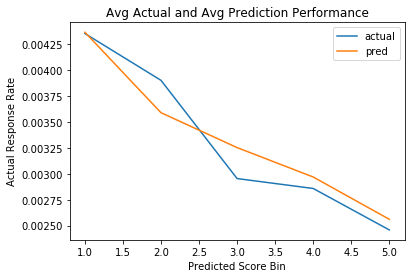

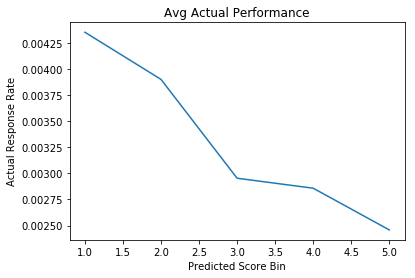

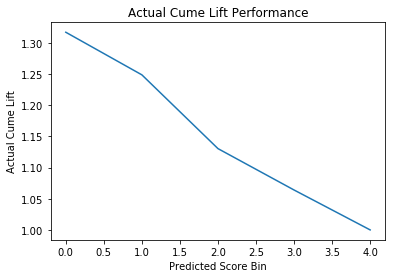

In [10]:
#predict test

#train
x1= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24_NORM_CT.fillna(0).values})
x2= dmatrix("cr(x, df=3) - 1", {"x":x_train.income.fillna(0).values})
x3= dmatrix("cr(x, df=3) - 1", {"x":x_train.Pen_ALL.fillna(0).values})
x4= dmatrix("cr(x, df=3) - 1", {"x":x_train.SHARE_CheckBAL.fillna(0).values})
x5= dmatrix("cr(x, df=3) - 1", {"x":x_train.Target_PreMover_20_Model_879.fillna(0).values})
x6= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24_NORM_CT_CHK.fillna(0).values})
x7= dmatrix("cr(x, df=3) - 1", {"x":x_train.new_hhs_24.fillna(0).values})
x8= dmatrix("cr(x, df=3) - 1", {"x":x_train.Pen_Check.fillna(0).values})
x9= dmatrix("cr(x, df=3) - 1", {"x":x_train.pred.fillna(0).values})
x10= dmatrix("cr(x, df=3) - 1", {"x":x_train.Home_value.fillna(0).values})
x11= dmatrix("cr(x, df=3) - 1", {"x":x_train.Mortgage_Liability.fillna(0).values})



xx1=build_design_matrices([x1.design_info], {"x":x_test.new_hhs_24_NORM_CT.fillna(0).values })
xx2=build_design_matrices([x2.design_info], {"x":x_test.income.fillna(0).values })
xx3=build_design_matrices([x3.design_info], {"x":x_test.Pen_ALL.fillna(0).values })
xx4=build_design_matrices([x4.design_info], {"x":x_test.SHARE_CheckBAL.fillna(0).values })
xx5=build_design_matrices([x5.design_info], {"x":x_test.Target_PreMover_20_Model_879.fillna(0).values })
xx6=build_design_matrices([x6.design_info], {"x":x_test.new_hhs_24_NORM_CT_CHK.fillna(0).values })
xx7=build_design_matrices([x7.design_info], {"x":x_test.new_hhs_24.fillna(0).values })
xx8=build_design_matrices([x8.design_info], {"x":x_test.Pen_Check.fillna(0).values })
xx9=build_design_matrices([x9.design_info], {"x":x_test.pred.fillna(0).values })
xx10=build_design_matrices([x10.design_info], {"x":x_test.Home_value.fillna(0).values })
xx11=build_design_matrices([x11.design_info], {"x":x_test.Mortgage_Liability.fillna(0).values })
            
DMA_test=x_test[['DMA_1',
    'DMA_2',
    'DMA_3',
    'DMA_4',
    'DMA_5',
    'DMA_6',
    'DMA_7',
    'DMA_8',
    'DMA_9',
    'DMA_10',
    'DMA_11',
    'DMA_12',
    'DMA_13',
    'DMA_14',
    'DMA_15',
    'DMA_16',
    'DMA_17',
    'DMA_18',
    'DMA_19',
    'DMA_20',
    'DMA_21',
    'DMA_22']]   
    

Z2=np.column_stack(
    [
DMA_test.values,
np.array(xx1[0]),
np.array(xx2[0]),
np.array(xx3[0]),
np.array(xx4[0]),
np.array(xx5[0]),
np.array(xx6[0]),
np.array(xx7[0]),
np.array(xx8[0]),
np.array(xx9[0]),
np.array(xx10[0]),
np.array(xx11[0])
    ])

pred=LR.predict_proba(Z2)[:,1]
d=np.column_stack([y_test.values,pred]) #out of fold
eval_model_results_binary(d,5)

AUC is: 0.561013715675
KS: 0.0998043949138
Total Responders: 1902.0
Lift Bin 1 (Vs Mean): 1.40903821635
Lift Bin 1 (Vs Last Bin): 1.98518518519


,Decile,Count,Responders,Actual Response Rate,Predicted Response Rate,Lift,Cume Count,Cume Responders,Cume Response Rate,Cume Lift,Min Predicted,Max Predicted
0,1,57557,268,0.004656,0.004746,1.409038,57557,268,0.004656,1.409038,0.004199,0.550054
1,2,57557,233,0.004048,0.003983,1.225022,115114,501,0.004352,1.317030,0.003812,0.004199
2,3,57557,230,0.003996,0.003689,1.209249,172671,731,0.004233,1.281103,0.003580,0.003812
3,4,57556,219,0.003805,0.003488,1.151436,230227,950,0.004126,1.248687,0.003403,0.003580
4,5,57557,176,0.003058,0.003325,0.925339,287784,1126,0.003913,1.184017,0.003250,0.003403
5,6,57557,164,0.002849,0.003179,0.862247,345341,1290,0.003735,1.130388,0.003109,0.003250
6,7,57556,163,0.002832,0.003040,0.857005,402897,1453,0.003606,1.091334,0.002970,0.003109
7,8,57557,166,0.002884,0.002898,0.872762,460454,1619,0.003516,1.064012,0.002821,0.002970
8,9,57557,148,0.002571,0.002728,0.778126,518011,1767,0.003411,1.032247,0.002621,0.002821
9,10,57557,135,0.002346,0.002394,0.709777,575568,1902,0.003305,1.000000,0.000000,0.002621


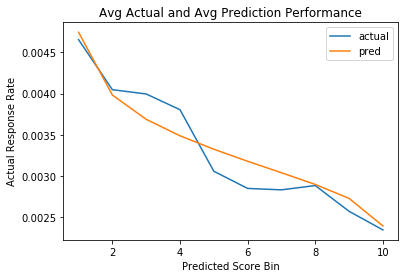

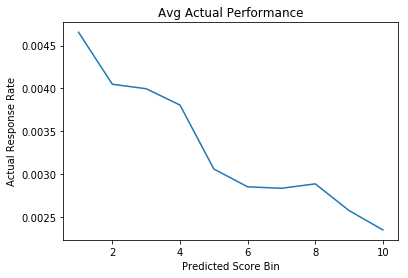

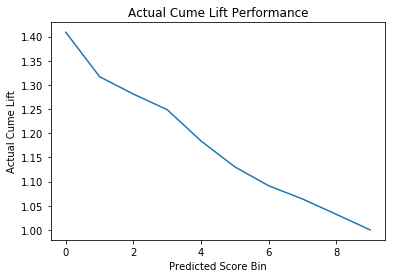

In [11]:
pred=LR.predict_proba(Z2)[:,1]
d=np.column_stack([y_test.values,pred]) #out of fold
eval_model_results_binary(d,10)

In [17]:
#migration analysis
def resp_decile_classify(x): 
    if x >= 0.02016828: 
        resp_decile_range=1 
    elif x >=0.0183238479987624 and x < 0.02016828:
        resp_decile_range=2
    elif x >=0.0171368020008659 and x < 0.0183238479987624:
        resp_decile_range=3
    elif x >=0.0162066398244529 and x < 0.0171368020008659 :
        resp_decile_range=4
    elif x >=0.0153569084145478 and x < 0.0162066398244529:
        resp_decile_range=5    
    elif x >=0.0145335720355378 and x < 0.0153569084145478:
        resp_decile_range=6
    elif x >=0.0136686706768234 and x < 0.0145335720355378:
        resp_decile_range=7
    elif x >=0.0126610871036991 and x < 0.0136686706768234:
        resp_decile_range=8
    elif x >=0.0111844466793064 and x < 0.0126610871036991:
        resp_decile_range=9
    elif x < 0.0111844466793064:
        resp_decile_range=10
    
    return(resp_decile_range)

x_test['original_decile']=x_test.pred.apply(resp_decile_classify) 
x_test['responder']=y_test.values

In [22]:
pred=LR.predict_proba(Z2)[:,1]
x=pd.DataFrame(pred, columns=['new_pred'])
x2=5-pd.qcut(x.new_pred,5,labels=False)

x_test['new_quintile'] =x2
x_test.head()

,new_hhs_24_NORM_CT,Home_value,Mortgage_Liability,income,closest_dist,Pen_ALL,SHARE_CheckBAL,Target_PreMover_20_Model_879,DEP_BAL_53_TO_NIELSEN,new_hhs_24_NORM_CT_CHK,GPR_IND,IXI_MM_PROP,Advantage_Length_of_Residen_823,DMA_1,DMA_2,DMA_3,DMA_4,DMA_5,DMA_6,DMA_7,DMA_8,DMA_9,DMA_10,DMA_11,DMA_12,DMA_13,DMA_14,DMA_15,DMA_16,DMA_17,DMA_18,DMA_19,DMA_20,DMA_21,DMA_22,new_hhs_24,Pen_Check,unique_id,Person_Seq_No_1_183,pred,original_decile,responder,new_quintile
0,0.022249,201.000000,18.000000,7,2.313901,0.114745,0.018248,26,0.018869,0.011731,14.000000,0.324279,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,55.000000,0.064935,5569225,00000000400000000381D7,0.017664,3,0,2
1,0.042521,211.000000,157.000000,8,1.157309,0.363584,0.055779,52,0.139269,0.023918,77.000000,0.278001,7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,112.000000,0.270447,21694805,010088BC030E0C0000051B,0.016982,4,0,3
2,0.031623,257.000000,259.000000,7,3.137035,0.160321,0.069738,67,nan,0.013352,12.000000,0.452906,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45.000000,0.116554,35104326,010088BC0310C60000007C,0.018270,3,0,3
3,0.014219,157.000000,nan,7,1.228292,0.089109,0.028764,36,0.017992,0.004168,45.000000,0.229137,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,58.000000,0.058624,3313,010088BE03119300000394,0.016674,4,0,1
4,0.039421,221.000000,107.000000,8,1.130166,0.130646,0.025191,71,nan,0.015552,42.000000,0.396043,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,109.000000,0.082467,8290596,010088BF030E0C000077EA,0.017469,3,0,1


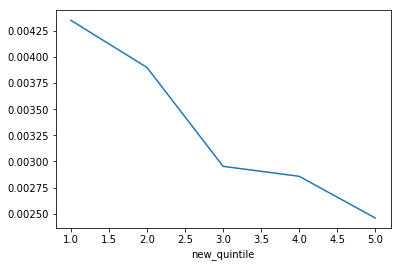

In [26]:
x_test.groupby(['new_quintile'])['responder'].mean().plot()

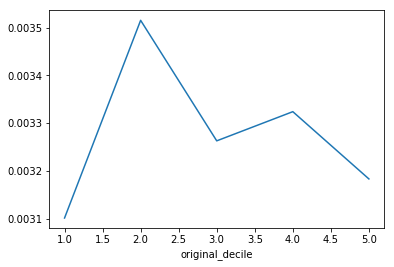

In [25]:
x_test.groupby(['original_decile'])['responder'].mean().plot()

In [30]:
pd.crosstab(x_test.original_decile,x_test.new_quintile)

new_quintile,1,2,3,4,5
original_decile,,,,,
1,8564,7452,8762,11039,15451
2,23868,21427,20141,20647,20305
3,35023,32596,32617,31630,27497
4,35074,38457,37905,37002,35972
5,12585,15181,15689,14795,15889
